In [47]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_RecCir.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [54]:
L = 300
h1 = 500
h2 = 200
rd = 100
rs = 10
rt = 125
dpml = 150

res = 40
l1 = L/res
l2 = l1/2

hrd = [0, h1/2]
meshfile = "geometry.msh"
geo_param = RecCirGeometry(L, h1, h2, rt, rd, rs, dpml, l1, l2)
MeshGenerator(geo_param, meshfile)

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 6
Info    : Reconstructing periodicity for curve connection 3 - 5
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Meshing curve 13 (Circle)
Info    : Meshing curve 2 (Line) as a copy of 6
Info    : Meshing curve 3 (Line) as a copy of 5
Info    : Done meshing 1D (0.001236 s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal)
Info    : Meshing surface 2 (Plane, Frontal)
Info    : Meshing surface 3 (Plane, Frontal)
Info    : Meshing surface 4 (Plane, 

In [55]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = [0.02 * L, 0.02 * L]  # Filter radius
β = 80.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = false          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])


control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)



Info    : Reading 'geometry.msh'...
Info    : 31 entities
Info    : 20590 nodes
Info    : 41394 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 5524, UnstructuredGrid(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 7)

gvalue = v2_vec' * O_mat * v2_vec = -2.821125457974134e-5 + 5.421010862427522e-20im


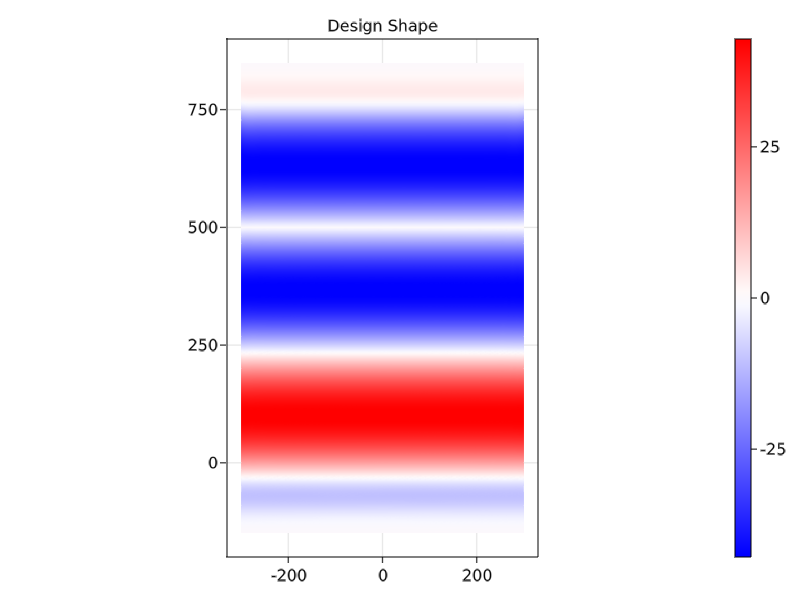

In [64]:

material = "Silver"
n_λ, k_λ = RefractiveIndex(material,main_path)
λ1 = 532
λ2 = 532
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = 1
μ = 1
R = 1e-10
LHp=[L/2, h1+h2]   # Start of PML for x,y > 0
LHn=[L/2, 0.1]       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nf, μ, R, dpml, LHp, LHn, 0)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nf, μ, R, dpml, LHp, LHn, 0)


N = num_free_dofs(gridap.FE_U)
kb = 0. * ω1
p0 = zeros(gridap.np)
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh

A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)

binc(v) = ∫(v)gridap.dΓ_s
b_inc = assemble_vector(binc, gridap.FE_V)

u1_vec = A1_mat\b_inc
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
O_mat = MatrixOc(ω2, nf^2; gridap)

braman(v) = ∫((x->GaussianD(x, hrd, [2,2]))*(∇(v) ⋅ ∇(u1h)))gridap.dΩ
b_raman = assemble_vector(braman, gridap.FE_V)
v2_vec = A2_mat' \ b_raman
v2h = FEFunction(gridap.FE_U, v2_vec)

@show gvalue = v2_vec'*O_mat*v2_vec

#fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
maxv = maximum(abs.(u1_vec))/1
fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
Colorbar(fig[1,2], plt)
ax.title = "Design Shape"
ax.aspect = AxisAspect((L+2*dpml)/(h1+h2+2*dpml))
#ax.aspect = AxisAspect(L/(h1))
#limits!(ax, -L/2, L/2, 0, h1)
fig

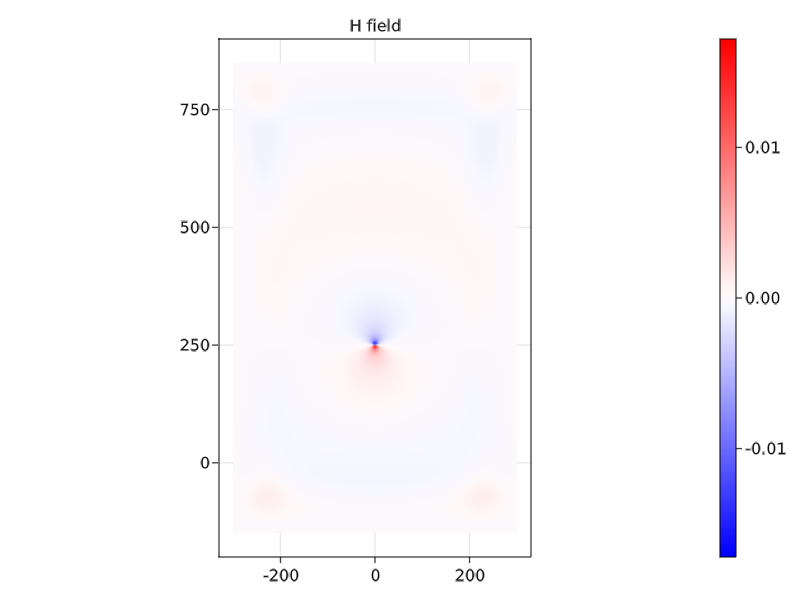

In [67]:
maxv = maximum(abs.(v2_vec))/1
fig, ax, plt = plot(gridap.Ω, real(v2h), colormap = :bwr, colorrange=(-maxv, maxv))
Colorbar(fig[1,2], plt)
ax.title = "H field"
ax.aspect = AxisAspect((L+2*dpml)/(h1+h2+2*dpml))
#ax.aspect = AxisAspect(L/(h1))
#limits!(ax, -L/2, L/2, 0, h1)
fig